# Forest Data

In [1]:
#load the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
import seaborn as sns
from keras.layers import Input, Dense, concatenate, Dropout, Conv1D, MaxPooling1D
from keras.models import Model
from keras.utils import to_categorical
import tensorflow.keras as keras
from sklearn.model_selection import cross_val_score
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.
/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

In [2]:
np.set_printoptions(suppress = True)

## Load the dataset

In [3]:
#load path here where the datasets reside
path = '../ten-datasets/'

#load the dataset into a dataframe
df_forestdata = pd.read_csv(path + 'Forest.csv')

In [4]:
#labels are in the last column, features are in the other columns
Y = df_forestdata.iloc[:,54]
X = df_forestdata.iloc[:,0:54]

In [5]:
#create 80/20 train/test split in the data using sklearn
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size =0.2, random_state = 123, stratify=Y)
#create binary labels for MLPs
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)

In [6]:
#the following function gives some default classification metrics that can be re-used
def model_fit_report(model,x_values,y_values_actual,y_values_predicted,y_values_probability,labels,DataSetType):
    print("Model Fit Results")
    print("")
    print (DataSetType + " Accuracy: %0.3f" % accuracy_score(y_values_actual,y_values_predicted))
    print("")
    
        
    matrix = confusion_matrix(y_values_actual, y_values_predicted,labels)#labels=lb.classes_
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.xticks(np.arange(len(labels))+0.5,labels)
    plt.ylabel('True label')
    plt.yticks(np.arange(len(labels))+0.5,labels)
    plt.show()

    #print("Confusion Matrix")
    #CM = plot_confusion_matrix(model,x_values,y_values_actual,values_format = 'n')
    #print (CM)
    #print("")
    #print (confusion_matrix(y_values_actual,y_values_predicted))
    #print("")
    print("Classification Report")
    print("")
    print (classification_report(y_values_actual,y_values_predicted))
    
  
    

In [7]:
#standardise the data
mms = MinMaxScaler()
x_train_scaled = mms.fit_transform(x_train)
x_test_scaled = mms.fit_transform(x_test)

## Logistic Regression

Model Fit Results

Train Accuracy: 0.707



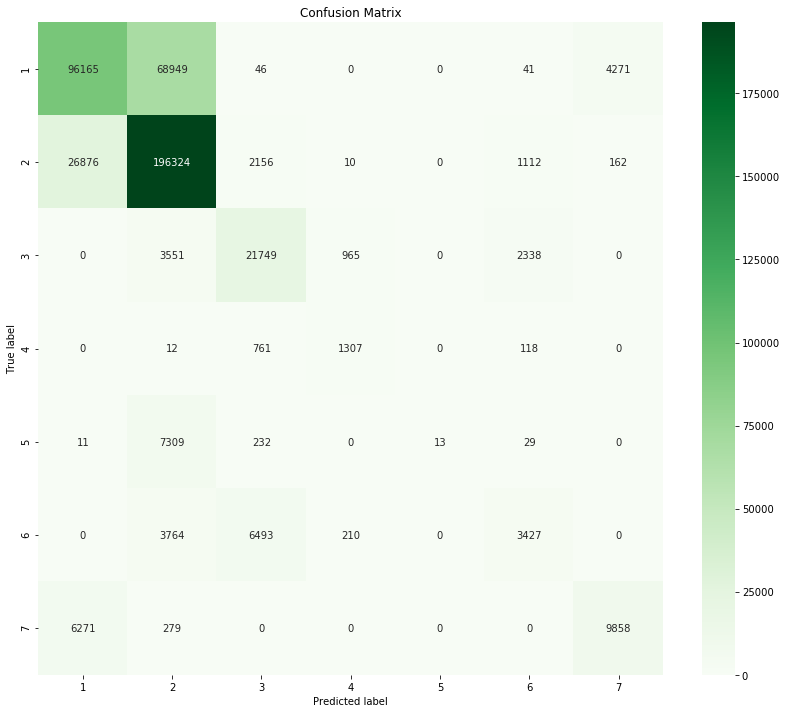

Classification Report

              precision    recall  f1-score   support

           1       0.74      0.57      0.64    169472
           2       0.70      0.87      0.77    226640
           3       0.69      0.76      0.72     28603
           4       0.52      0.59      0.56      2198
           5       1.00      0.00      0.00      7594
           6       0.49      0.25      0.33     13894
           7       0.69      0.60      0.64     16408

    accuracy                           0.71    464809
   macro avg       0.69      0.52      0.52    464809
weighted avg       0.71      0.71      0.69    464809

Model Fit Results

Test Accuracy: 0.706



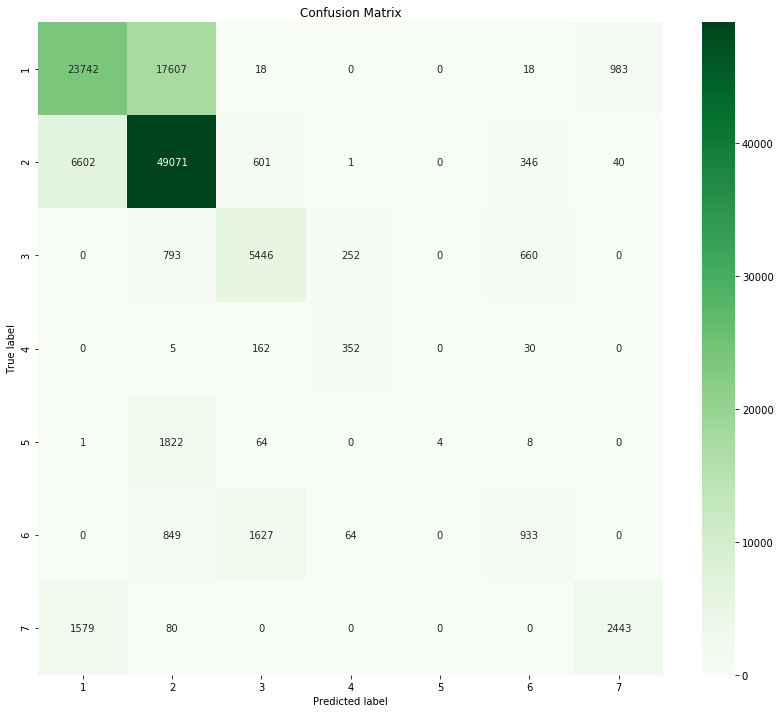

Classification Report

              precision    recall  f1-score   support

           1       0.74      0.56      0.64     42368
           2       0.70      0.87      0.77     56661
           3       0.69      0.76      0.72      7151
           4       0.53      0.64      0.58       549
           5       1.00      0.00      0.00      1899
           6       0.47      0.27      0.34      3473
           7       0.70      0.60      0.65      4102

    accuracy                           0.71    116203
   macro avg       0.69      0.53      0.53    116203
weighted avg       0.71      0.71      0.69    116203



In [20]:
#start with a default logistic regression with no regularisation (C=100)

lr = LogisticRegression(C=100,max_iter = 100, tol=.1,solver='sag')
lr.fit(x_train_scaled,y_train)


#need to add 1 to the assigned class, otherwise the classes start from zero which isn't correct.
y_train_predict = lr.predict_proba(x_train_scaled).argmax(axis = 1)+1
model_fit_report(lr,x_train_scaled,y_train,y_train_predict,lr.predict_proba(x_train_scaled),np.unique(y_train),'Train')

#get results for test dataset
y_test_predict = lr.predict_proba(x_test_scaled).argmax(axis = 1)+1
model_fit_report(lr,x_test_scaled,y_test,y_test_predict,lr.predict_proba(x_test_scaled),np.unique(y_train),'Test')

### Optimising Regularisation ('C')

In [21]:
#define the values of C to test and then use validation_curve from sklearn to evaluate
parameter_range = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
train_scores, test_scores = validation_curve(estimator = lr, X=x_train_scaled, y=y_train, param_name ='C',param_range=parameter_range,cv=10)

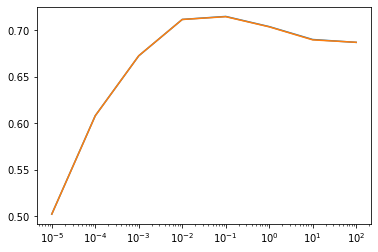

In [22]:

#obtain the mean results from the samples
train_mean = np.mean(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)

#plot the results
plt.plot(parameter_range,train_mean)
plt.plot(parameter_range,test_mean)
plt.xscale('log')

Not sure why the training results decrease in line with validation results. Was expecting train results to get
better with increasing C (ie training should overfit)

0.1
Model Fit Results

Train Accuracy: 0.642



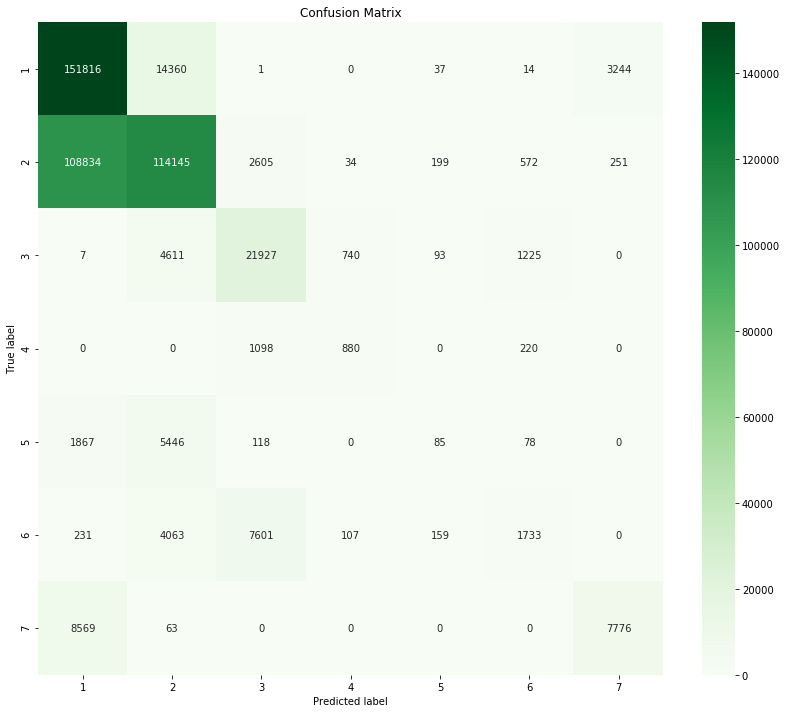

Classification Report

              precision    recall  f1-score   support

           1       0.56      0.90      0.69    169472
           2       0.80      0.50      0.62    226640
           3       0.66      0.77      0.71     28603
           4       0.50      0.40      0.44      2198
           5       0.15      0.01      0.02      7594
           6       0.45      0.12      0.20     13894
           7       0.69      0.47      0.56     16408

    accuracy                           0.64    464809
   macro avg       0.54      0.45      0.46    464809
weighted avg       0.68      0.64      0.62    464809

Model Fit Results

Test Accuracy: 0.644



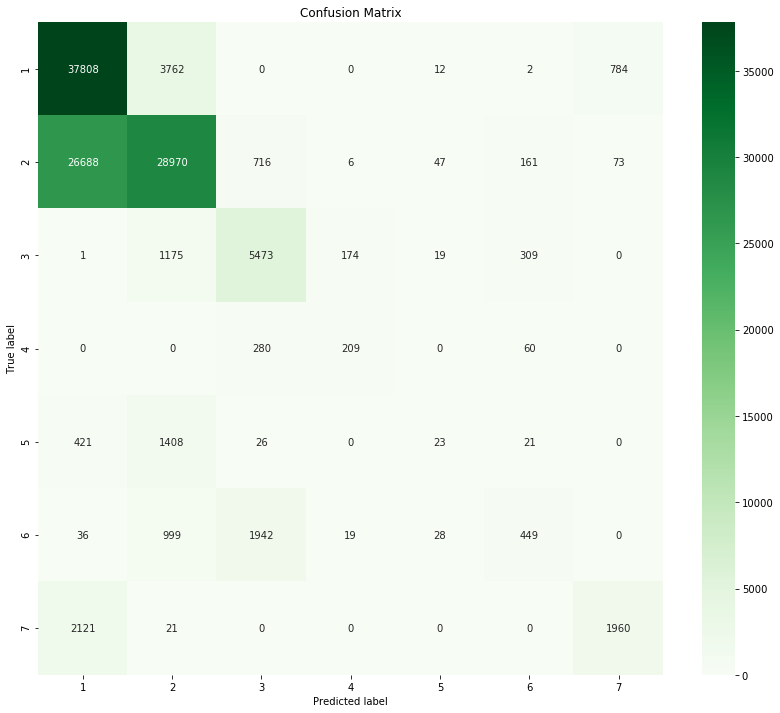

Classification Report

              precision    recall  f1-score   support

           1       0.56      0.89      0.69     42368
           2       0.80      0.51      0.62     56661
           3       0.65      0.77      0.70      7151
           4       0.51      0.38      0.44       549
           5       0.18      0.01      0.02      1899
           6       0.45      0.13      0.20      3473
           7       0.70      0.48      0.57      4102

    accuracy                           0.64    116203
   macro avg       0.55      0.45      0.46    116203
weighted avg       0.68      0.64      0.63    116203



In [23]:
#find the test value with highest accuracy score and corresponding parameter as the optimal C value
optimal_C = parameter_range[test_mean.argmax()]
print(optimal_C)
#and then use that in the final logistic regression
lr = LogisticRegression(C=optimal_C,max_iter = 100, tol=1,solver='sag')
lr.fit(x_train_scaled,y_train)
#need to add 1 to the assigned class, otherwise the classes start from zero which isn't correct.
y_train_predict = lr.predict_proba(x_train_scaled).argmax(axis = 1)+1
model_fit_report(lr,x_train_scaled,y_train,y_train_predict,lr.predict_proba(x_train_scaled),np.unique(y_train),'Train')
#get results for test dataset
y_test_predict = lr.predict_proba(x_test_scaled).argmax(axis = 1)+1
model_fit_report(lr,x_test_scaled,y_test,y_test_predict,lr.predict_proba(x_test_scaled),np.unique(y_train),'Test')

## Logistc Regression with PCA

In [24]:
#get the principal components from the scaled data and use that in the logistic regression
from sklearn.decomposition import PCA
pca = PCA(n_components = 12,random_state = 123) #n_components is estimated from commented out section below
x_train_pca = pca.fit_transform(x_train_scaled)
lr = LogisticRegression(C=.001,max_iter = 100, tol=.1,solver='sag')
lr.fit(x_train_pca,y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.1, verbose=0,
                   warm_start=False)

Model Fit Results

Train Accuracy: 0.610



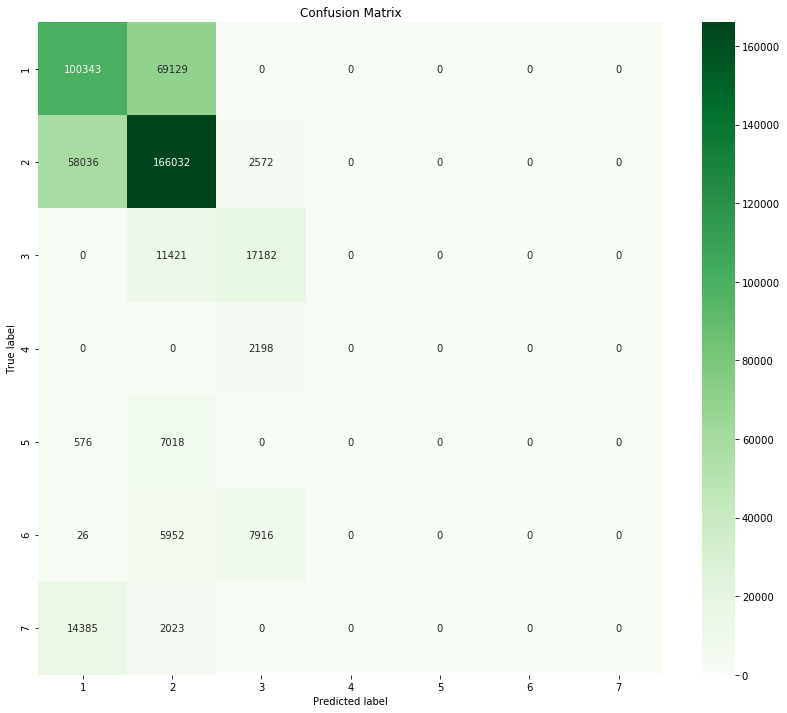

Classification Report



/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.58      0.59      0.59    169472
           2       0.63      0.73      0.68    226640
           3       0.58      0.60      0.59     28603
           4       0.00      0.00      0.00      2198
           5       0.00      0.00      0.00      7594
           6       0.00      0.00      0.00     13894
           7       0.00      0.00      0.00     16408

    accuracy                           0.61    464809
   macro avg       0.26      0.28      0.26    464809
weighted avg       0.56      0.61      0.58    464809

Model Fit Results

Test Accuracy: 0.609



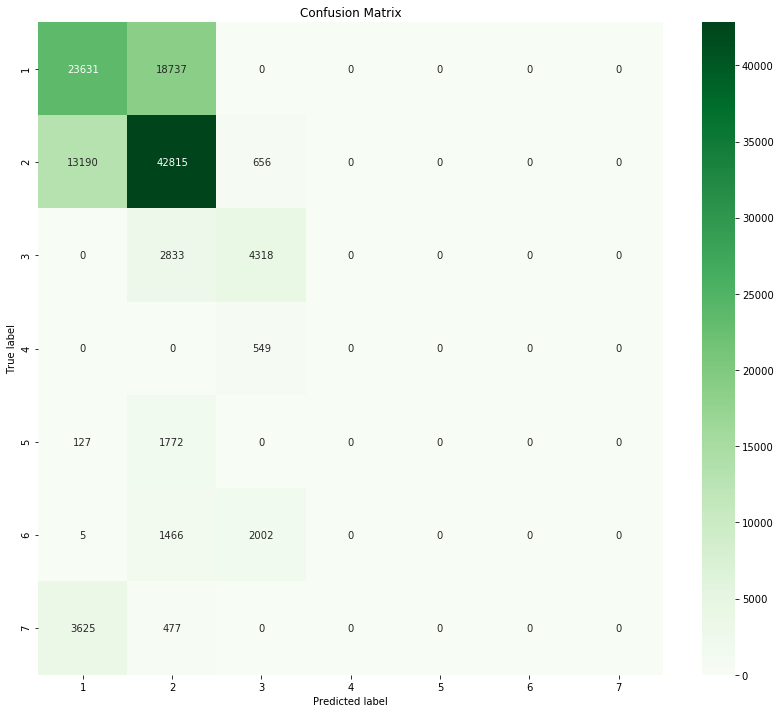

Classification Report



/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.58      0.56      0.57     42368
           2       0.63      0.76      0.69     56661
           3       0.57      0.60      0.59      7151
           4       0.00      0.00      0.00       549
           5       0.00      0.00      0.00      1899
           6       0.00      0.00      0.00      3473
           7       0.00      0.00      0.00      4102

    accuracy                           0.61    116203
   macro avg       0.25      0.27      0.26    116203
weighted avg       0.55      0.61      0.58    116203



In [25]:
#get results for training dataset
y_train_predict = lr.predict_proba(x_train_pca).argmax(axis = 1)+1
model_fit_report(lr,x_train_pca,y_train,y_train_predict,lr.predict_proba(x_train_pca),np.unique(y_train),'Train')

#get results for test dataset
x_test_pca = pca.fit_transform(x_test_scaled)
y_test_predict = lr.predict_proba(x_test_pca).argmax(axis = 1)+1
model_fit_report(lr,x_test_pca,y_test,y_test_predict,lr.predict_proba(x_test_pca),np.unique(y_train),'Test')



Results using PCA appear worse than using all features. 

In [26]:
#The following is useful to get an idea of how many principle components might be appropriate

#pca = PCA(n_components = None)
#x_train_pca = pca.fit_transform(x_train_scaled)
#print(pca.explained_variance_ratio_)

## Random Forest

Model Fit Results

Train Accuracy: 0.687



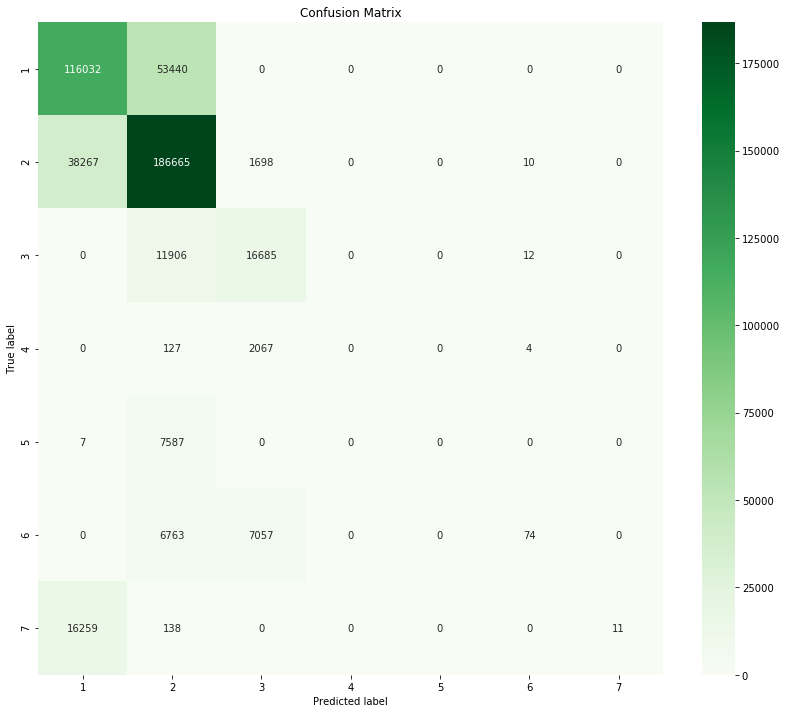

Classification Report



/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.68      0.68      0.68    169472
           2       0.70      0.82      0.76    226640
           3       0.61      0.58      0.59     28603
           4       0.00      0.00      0.00      2198
           5       0.00      0.00      0.00      7594
           6       0.74      0.01      0.01     13894
           7       1.00      0.00      0.00     16408

    accuracy                           0.69    464809
   macro avg       0.53      0.30      0.29    464809
weighted avg       0.68      0.69      0.65    464809

Model Fit Results

Test Accuracy: 0.687



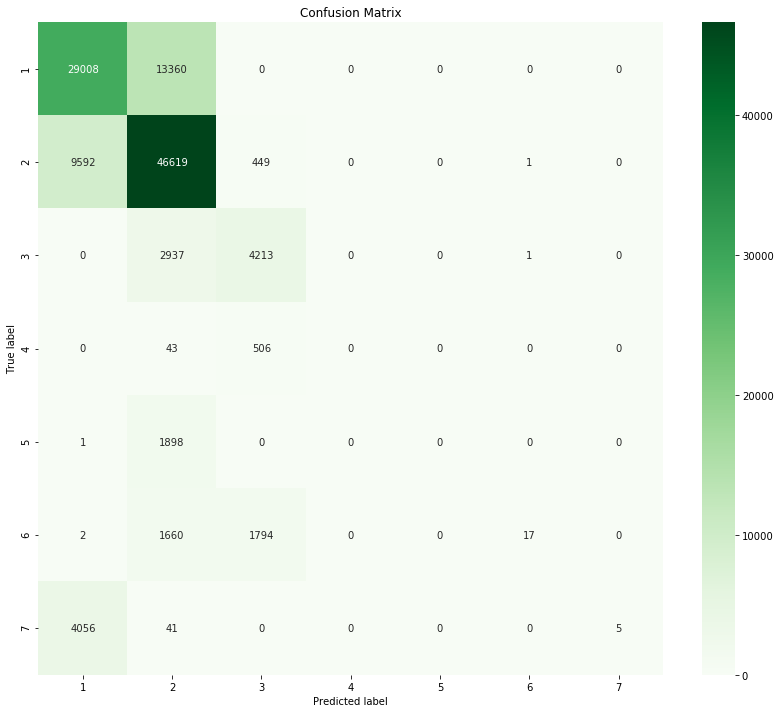

Classification Report



/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.68      0.68      0.68     42368
           2       0.70      0.82      0.76     56661
           3       0.61      0.59      0.60      7151
           4       0.00      0.00      0.00       549
           5       0.00      0.00      0.00      1899
           6       0.89      0.00      0.01      3473
           7       1.00      0.00      0.00      4102

    accuracy                           0.69    116203
   macro avg       0.55      0.30      0.29    116203
weighted avg       0.69      0.69      0.65    116203



array([0.1745429 , 0.06531176, 0.05701175, 0.06772851, 0.07137672,
       0.08133137, 0.0591524 , 0.06709973, 0.06382969, 0.06918463,
       0.01334535, 0.00601251, 0.01139442, 0.03384872, 0.00113357,
       0.0079507 , 0.00152233, 0.01328764, 0.00159064, 0.00300518,
       0.00000079, 0.0000333 , 0.        , 0.01433316, 0.00376979,
       0.00801614, 0.00231948, 0.00065449, 0.        , 0.00130981,
       0.00211056, 0.00016778, 0.00045558, 0.00381902, 0.00017344,
       0.01379442, 0.01358916, 0.00433118, 0.00001528, 0.00019648,
       0.00019336, 0.00015238, 0.01006369, 0.00560973, 0.00441555,
       0.00616252, 0.00702682, 0.00073789, 0.00146056, 0.00020807,
       0.        , 0.00957465, 0.01007452, 0.0055699 ])

In [27]:
#setup and train the forest. The n_estimators of 100 is determined from the optimisation below
forest = RandomForestClassifier(criterion='gini', n_estimators = 100, random_state =123,max_samples =100)
forest.fit(x_train,y_train)

#get the training results
y_train_predict = forest.predict(x_train)
model_fit_report(forest,x_train,y_train,y_train_predict,forest.predict_proba(x_train_scaled),np.unique(y_train),'Train')

#get the test results
y_test_predict = forest.predict(x_test)
model_fit_report(forest,x_test,y_test,y_test_predict,forest.predict_proba(x_test),np.unique(y_train),'Test')

#just for interest, understand what features are dominating
importances = forest.feature_importances_
importances


### Optimise the number of trees (n_estimators)

In [28]:
parameter_range = [10,25,50,75,100,150]
train_scores, test_scores = validation_curve(estimator = forest, X=x_train, y=y_train, param_name ='n_estimators',param_range=parameter_range,cv=10)

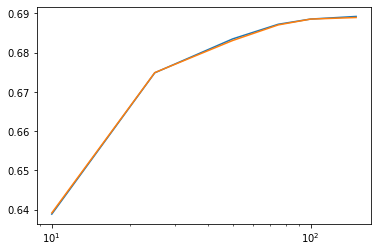

In [29]:
train_mean = np.mean(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
plt.plot(parameter_range,train_mean)
plt.plot(parameter_range,test_mean)
plt.xscale('log')


### SVM

process takes very long time to train (hours)!! Too long to run. Can only train on about 20,000 samples

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear',C=1.0, random_state=1, probability = True )
svm.fit(x_train_scaled[0:20000],y_train[0:20000])


In [ ]:
y_train_predict = svm.predict_proba(x_train_scaled[0:20000]).argmax(axis = 1)
print ("SVM Train Accuracy: %.3f" % accuracy_score(y_train[0:20000],y_train_predict))
model_fit_report(svm,x_train_scaled[0:20000],y_train[0:20000],y_train_predict,
                 svm.predict_proba(x_train_scaled[0:1]),np.unique(y_train))
                                                                                               
y_test_predict = svm.predict_proba(x_test_scaled[0:20000]).argmax(axis = 1)
print ("SVM Test Accuracy: %.3f" % accuracy_score(y_test[0:20000],y_test_predict))
model_fit_report(svm,x_test_scaled[0:20000],y_test[0:20000],y_test_predict,
                 svm.predict_proba(x_test_scaled[0:1]),np.unique(y_test))



### MLP with Keras

In [9]:
#standard parameters for the various NN architectures
epochs = 10
batch_size = 64

### Two Layer, 100 Unit MLP

In [ ]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = x_train_scaled.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = 100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
    units=y_train_binary.shape[1],
    input_dim=100,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation ='softmax'))



model.compile(optimizer='adam',loss ='categorical_crossentropy',metrics=['accuracy'])
model.summary()
history = model.fit(x_train_scaled,y_train_binary,batch_size=batch_size,epochs =epochs, verbose =1, 
                    validation_data=(x_test_scaled,y_test_binary))

#training results
y_train_predict = model.predict_classes(x_train_scaled,verbose=0)
print ("Keras MLP Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))
print(confusion_matrix(y_train,y_train_predict))
#testing results
y_test_predict = model.predict_classes(x_test_scaled,verbose=0)
print ("Keras MLP Test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))
print(confusion_matrix(y_test,y_test_predict))

### Two Layer, 200 Unit MLP

In [ ]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units = 200, 
        input_dim = x_train_scaled.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 200, 
        input_dim = 200,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
    units=y_train_binary.shape[1],
    input_dim=200,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation ='softmax'))


model.compile(optimizer='adam',loss ='categorical_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(x_train_scaled,y_train_binary,batch_size=batch_size,epochs =epochs, verbose =1, 
                    validation_data=(x_test_scaled,y_test_binary))
#training results
y_train_predict = model.predict_classes(x_train_scaled,verbose=0)
print ("Keras MLP Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))
print(confusion_matrix(y_train,y_train_predict))
#testing results
y_test_predict = model.predict_classes(x_test_scaled,verbose=0)
print ("Keras MLP Test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))
print(confusion_matrix(y_test,y_test_predict))

### Two Layer, 300 Unit MLP

In [ ]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units = 300, 
        input_dim = x_train_scaled.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 300, 
        input_dim = 300,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
    units=y_train_binary.shape[1],
    input_dim=300,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation ='softmax'))


model.compile(optimizer='adam',loss ='categorical_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(x_train_scaled,y_train_binary,batch_size=batch_size,epochs =epochs, verbose =1, 
                    validation_data=(x_test_scaled,y_test_binary))
#training results
y_train_predict = model.predict_classes(x_train_scaled,verbose=0)
print ("Keras MLP Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))
print(confusion_matrix(y_train,y_train_predict))
#testing results
y_test_predict = model.predict_classes(x_test_scaled,verbose=0)
print ("Keras MLP Test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))
print(confusion_matrix(y_test,y_test_predict))

### Three Layer, 100 Unit MLP

In [ ]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = x_train_scaled.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = 100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = 100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
    units=y_train_binary.shape[1],
    input_dim=100,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation ='softmax'))

model.compile(optimizer='adam',loss ='categorical_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(x_train_scaled,y_train_binary,batch_size=batch_size,epochs =epochs, verbose =1, 
                    validation_data=(x_test_scaled,y_test_binary))

#training results
y_train_predict = model.predict_classes(x_train_scaled,verbose=0)
print ("Keras MLP Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))
print(confusion_matrix(y_train,y_train_predict))
#testing results
y_test_predict = model.predict_classes(x_test_scaled,verbose=0)
print ("Keras MLP Test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))
print(confusion_matrix(y_test,y_test_predict))

### Four Layer, 100 unit MLP

In [ ]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = x_train_scaled.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = 100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = 100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = 100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(keras.layers.Dropout(0.5,seed=123))

model.add(
    keras.layers.Dense(
    units=y_train_binary.shape[1],
    input_dim=100,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation ='softmax'))



model.compile(optimizer='adam',loss ='categorical_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(x_train_scaled,y_train_binary,batch_size=batch_size,epochs =epochs, verbose =1, 
                    validation_data=(x_test_scaled,y_test_binary))
#training results
y_train_predict = model.predict_classes(x_train_scaled,verbose=0)
print ("Keras MLP Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))
print(confusion_matrix(y_train,y_train_predict))
#testing results
y_test_predict = model.predict_classes(x_test_scaled,verbose=0)
print ("Keras MLP Test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))
print(confusion_matrix(y_test,y_test_predict))


### Deep and Shallow MLP
Using functional model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 54)           0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 100)          5500        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 100)          0           dense_8[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 100)          10100       dropout_7[0][0]                  
____________________________________________________________________________________________

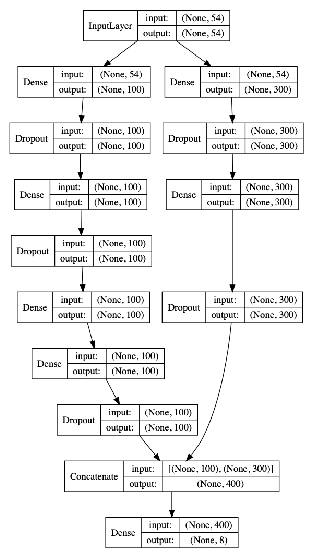

CPU times: user 12min 10s, sys: 3min 25s, total: 15min 36s
Wall time: 4min 26s


In [10]:
%%time


input_data = Input(shape=x_train_scaled.shape[1:])

#deep stream
deep_dense1 = Dense(100, activation='relu')(input_data)
deep_drop1 = Dropout(0.25)(deep_dense1)
deep_dense2 = Dense(100, activation='relu')(deep_drop1)
deep_drop2 = Dropout(0.25)(deep_dense2)
deep_dense3 = Dense(100, activation='relu')(deep_drop2)
deep_drop3 = Dropout(0.25)(deep_dense3)
deep_dense4 = Dense(100, activation='relu')(deep_dense3)
deep_drop4 = Dropout(0.25)(deep_dense4)

#shallow stream
shallow_dense1 = Dense(300, activation='relu')(input_data)
shallow_drop1 = Dropout(0.25)(shallow_dense1)
shallow_dense2 = Dense(300, activation='relu')(shallow_drop1)
shallow_drop2 = Dropout(0.25)(shallow_dense2)

combined = concatenate([deep_drop4,shallow_drop2])


#result
result = Dense(y_train_binary.shape[1], activation='softmax')(combined)

# this model maps an input to its reconstruction
MLP = Model(input_data, result)


MLP.summary()


# compile model
MLP.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])


hist = MLP.fit(x_train_scaled,y_train_binary,
                epochs=epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_scaled,y_test_binary))

#encode_imgs_train = enc.predict(train_images) 
#encode_imgs_test = enc.predict(test_images) 

#decode_imgs_train = autoencoder.predict(train_images) 
#decode_imgs_test = autoencoder.predict(test_images) 

#print(encode_imgs_test.shape)


image_name = 'forest_ann_model.png'
plot_model(MLP,to_file=image_name,show_shapes=True,show_layer_names=False,rankdir='TB')
plt.figure(figsize=(10,10))
img = plt.imread(image_name)
plt.imshow(img)
plt.axis('off')
plt.show()

### 1D CNN

In [11]:
x_train_scaled.shape

(464809, 54)

In [12]:
x_train_scaled = x_train_scaled[:, :, np.newaxis]
x_test_scaled = x_test_scaled[:, :, np.newaxis]

print(x_train_scaled.shape)
print(x_test_scaled.shape)


(464809, 54, 1)
(116203, 54, 1)


In [13]:
x_train_scaled.shape[1:]

(54, 1)

In [14]:
y_test = np.array(y_test)

In [15]:
y_train

535880    1
176049    1
322055    2
143859    1
568085    2
         ..
116444    1
186891    2
170470    2
522001    7
163318    2
Name: Cover_Type, Length: 464809, dtype: int64

In [16]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.layers import Input, Conv1D, Conv2D, BatchNormalization, Activation, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Dense

In [17]:
x_train_scaled.shape

(464809, 54, 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 20)            120       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 20)            2020      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 20)            0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 20)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               154112    
_________________________________________________________________
dense_16 (Dense)             (None, 8)                

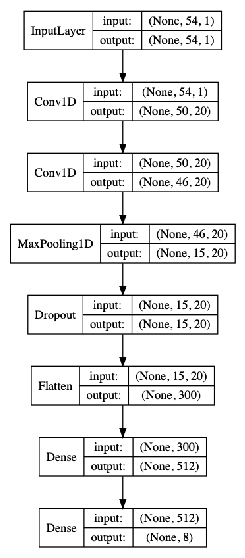

In [18]:
CNN = Sequential()


CNN.add(Conv1D(20, 5, activation='relu', input_shape=x_train_scaled.shape[1:], strides=1))
CNN.add(Conv1D(20, 5))
CNN.add(MaxPooling1D(pool_size=3))
CNN.add(Dropout(0.25))

CNN.add(Flatten())


CNN.add(Dense(512, activation='relu'))

CNN.add(Dense(8, activation='softmax'))
CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    

CNN.summary()

#history = model.fit(x_train_scaled,y_train,batch_size=batch_size,epochs =2, verbose =1)
history = CNN.fit(x_train_scaled,y_train_binary,batch_size=batch_size,epochs =10, verbose =1,
              validation_data=(x_test_scaled,y_test_binary))


image_name = 'forest_cnn_model.png'
plot_model(CNN,to_file=image_name,show_shapes=True,show_layer_names=False,rankdir='TB')
plt.figure(figsize=(10,10))
img = plt.imread(image_name)
plt.imshow(img)
plt.axis('off')
plt.show()